# 1. Import Requitred Libraries and setup Train Data

In [3]:
## for data
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for statistical tests
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm
## for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
## for explainer
from lime import lime_tabular

In [4]:
#Cleaning or preprocessing the the data
dtf = pd.read_csv("HousePrice-train.csv")
cols = ["Id","OverallQual","GrLivArea","GarageCars", 
        "GarageArea","TotalBsmtSF","FullBath",
        "YearBuilt","YearRemodAdd",
        "LotFrontage","MSSubClass","SalePrice"]
dtf = dtf[cols]
dtf.head()

,Id,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,FullBath,YearBuilt,YearRemodAdd,LotFrontage,MSSubClass,SalePrice
0,1,7,1710,2,548,856,2,2003,2003,65.0,60,208500
1,2,6,1262,2,460,1262,2,1976,1976,80.0,20,181500
2,3,7,1786,2,608,920,2,2001,2002,68.0,60,223500
3,4,7,1717,3,642,756,1,1915,1970,60.0,70,140000
4,5,8,2198,3,836,1145,2,2000,2000,84.0,60,250000


## 2. EDA
We first do some exploratory data analysis to summarize the main characteristics of this dataset. This can help us to understand what the data can tell us beyond the formal modeling or hypothesis testing task.


We start by getting an overview of the whole dataset. We want to know how many categorical and numerical variables in the data set and what is the proportion of missing data.

We are going to define a function "*utils_recognize_type*" to help us recognize numerical and categorical variables.

### A. Dividing data Into Either catergorical or Numeric Columns

In [5]:
#Idnetifying Categorical and Numeric coulumns using a function
'''
Recognize whether a column is numerical or categorical.
:parameter
    :param dtf: dataframe - input data
    :param col: str - name of the column to analyze
    :param max_cat: num - max number of unique values to recognize a column as categorical
:return
    "cat" if the column is categorical or "num" otherwise
'''
def utils_recognize_type(dtf, col, max_cat=20):
    if (dtf[col].dtype == "O") | (dtf[col].nunique() < max_cat):  # "O" means (python) objects
        return "cat"
    else:
        return "num"

### B. Visuliaze Data Table columns  with Null Values

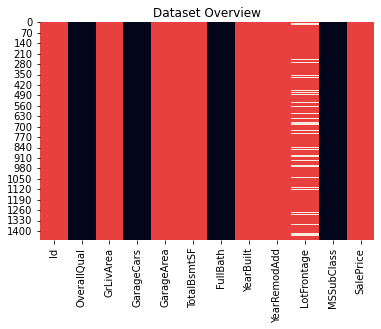

 Categerocial   Numeric   NaN 


In [6]:

#This is nothing but a tehcniuq to visualies Three things with help of heatmap:
#1. Categorical columns in a data frame
#2. Numerical columns in a data frame
#3. Null VaLUES in a data frame

dic_cols = {col:utils_recognize_type(dtf, col, max_cat=20) for col in dtf.columns} #Making dictionary for col types
heatmap = dtf.isnull()
for k,v in dic_cols.items():
    if v == "num":
        heatmap[k] = heatmap[k].apply(lambda x: 0.6 if x is False else 1)
    else:
        heatmap[k] = heatmap[k].apply(lambda x: 0 if x is False else 1)
sns.heatmap(heatmap, cbar=False).set_title('Dataset Overview')
plt.show()
print("\033[6;37;40m Categerocial ", "\033[1;30;41m Numeric ", "\033[1;30;47m NaN ")

# Based on the python ANSI codes, define the background color and tex color.

In [9]:
dtf = dtf.set_index("Id")
dtf = dtf.rename(columns={"SalePrice":"Y"})

### C. Inspecing our Dpenedent Column

The column which we are going to put on Y-axis, We should ispect about it from the historical data set before modeling

In [26]:
np.round(dtf["Y"].describe() ,decimals=2)

count      1460.0
mean     180921.2
std       79442.5
min       34900.0
25%      129975.0
50%      163000.0
75%      214000.0
max      755000.0
Name: Y, dtype: float64

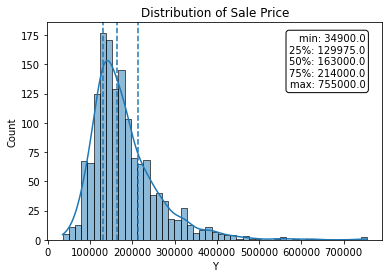

In [42]:
#Lets Plot a detailed histogram of this Price our dependent column
x = "Y"
fig, ax = plt.subplots()
ax.title.set_text('Distribution of Sale Price')
variable = dtf[x].fillna(dtf[x].mean())
sns.histplot(variable, kde=True)


# Lets also make a text box for the graph for detailed information
#des means description
des = dtf[x].describe()
#Following is the code to add a vertical line on histgram from a certain value on X Axis
ax.axvline(des["25%"], ls='--')
ax.axvline(des["50%"], ls='--')
ax.axvline(des["75%"], ls='--')
des = round(des, 2).apply(lambda x: str(x))


#Joining all the description from the box
box = '\n'.join(("min: "+des["min"], "25%: "+des["25%"], "50%: "+des["50%"], "75%: "+des["75%"], "max: "+des["max"]))

#Making a Text box for the Histgram
ax.text(0.95, 0.95, box, transform=ax.transAxes, fontsize=10, va='top', 
        ha="right", bbox=dict(boxstyle='round', facecolor='white', alpha=1))

plt.show()

### D. impact of Categorical Column and their values on Our dependent Variable

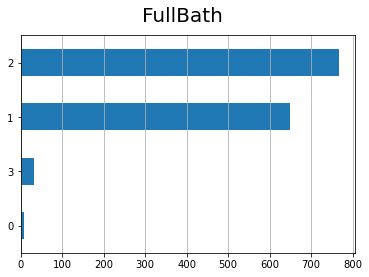

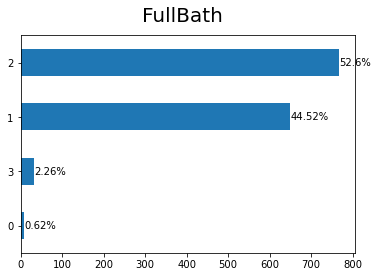

In [49]:
#Lets see how our data is speard for number of Full bath types houses


#Simple bar chart
x = "FullBath"
ax = dtf[x].value_counts().sort_values().plot(kind="barh")
ax.grid(axis="x")
plt.suptitle(x, fontsize=20)
plt.show()


#Bar chart with %
x = "FullBath"
ax = dtf[x].value_counts().sort_values().plot(kind="barh")
totals= []
for i in ax.patches:
    totals.append(i.get_width())
total = sum(totals)
for i in ax.patches:
     ax.text(i.get_width()+.3, i.get_y()+.20, 
     str(round((i.get_width()/total)*100, 2))+'%', 
     fontsize=10, color='black')
#ax.grid(axis="x")
plt.suptitle(x, fontsize=20)
plt.show()

Next, we have to check the bivariate distribution to understand if one variable has predictive power of our dependent variable or not. 

We first check the **categorical vs numerical** case by comparing *FullBath* and *Y*. There are some options to do this:

- Option 1: We can split the population (the whole set of observations) into 4 samples: the portion of houses with 0 bathroom (FullBath = 0), 1 bathroom (FullBath = 1), and so on. Then we plot and compare densities of the 4 samples, if the distributions are different then the variable is predictive because the 4 groups have different patterns.
- Option 2: We can also roup the numerical variable (Y) in bins (subsamples) and plot the composition of each bin, if the proportion of the categories is similar in all of them then the variable is not predictive.
- Option 3: The last optoin is to plot and compare the box plots of the 4 samples to spot different behaviors of the outliers.

/Users/ajaythakur/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/ajaythakur/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/ajaythakur/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figur

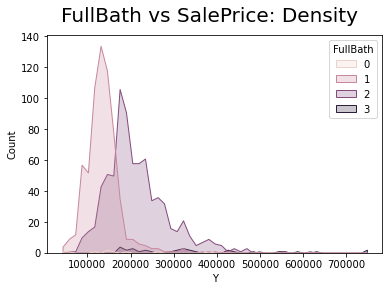

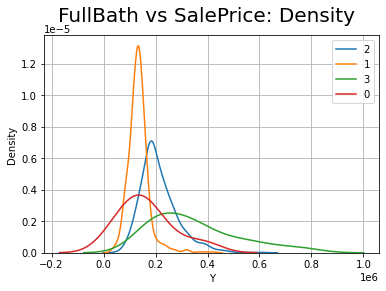

In [60]:
#Option 1: We can split the population (the whole set of observations) into 4 samples: the portion\
#of houses with 0 bathroom (FullBath = 0), 1 bathroom (FullBath = 1), and so on. Then we plot and\
#compare densities of the 4 samples, if the distributions are different then the variable is predictive\
#because the 4 groups have different patterns.



#Distribution of price w.r,t Full bath
#Note that this is just histrgram in form of plot for each value in Full bath column
fig, ax = plt.subplots()
fig.suptitle("FullBath vs SalePrice: Density", fontsize=20)
sns.histplot(data = dtf, x = "Y", hue = "FullBath", element="poly"); 



#Beow is another way to visulize same above graph
cat, num = "FullBath", "Y"
fig, ax = plt.subplots()
fig.suptitle("FullBath vs SalePrice: Density", fontsize=20)

for i in dtf[cat].unique():
    sns.distplot(dtf[dtf[cat]==i][num], hist=False, label= i, ax=ax)
plt.legend()
ax.grid(True)

FullBath                2    1   3  0
Y                                    
(34900.0, 106475.0]    23  120   0  2
(106475.0, 124000.0]   22  126   0  1
(124000.0, 135500.0]   29  115   0  0
(135500.0, 147000.0]   45  103   0  2
(147000.0, 163000.0]   53   89   0  1
(163000.0, 179280.0]   92   48   4  0
(179280.0, 198620.0]  126   16   3  1
(198620.0, 230000.0]  131   14   4  0
(230000.0, 278000.0]  131   10   2  1
(278000.0, 755000.0]  116    8  20  1


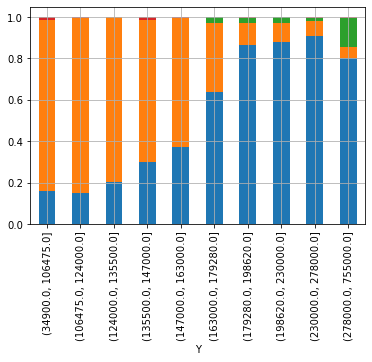

In [61]:
#Option 2: We can also roup the numerical variable (Y) in bins (subsamples) and plot the composition of each bin\
#if the proportion of the categories is similar in all of them then the variable is not predictive.

cat, num = "FullBath", "Y"
breaks = np.quantile(dtf[num], q=np.linspace(0,1,11))
tmp = dtf.groupby([cat, pd.cut(dtf[num], breaks, duplicates='drop')]).size().unstack().T
tmp = tmp[dtf[cat].unique()]
print(tmp)

#Drawing stack Bar chart 
tmp["tot"] = tmp.sum(axis=1)
for col in tmp.drop("tot", axis=1).columns:
    tmp[col] = tmp[col] / tmp["tot"] 
tmp.drop("tot", axis=1).plot(kind='bar', stacked=True, legend=False, grid=True)
plt.show()

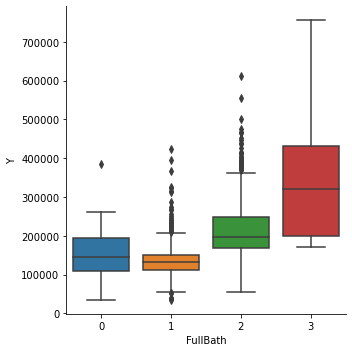

In [62]:
#Option 3: The last optoin is to plot and compare the box plots of the 4 samples to spot different behaviors\
#of the outliers.
    
sns.catplot(x=cat, y=num, data=dtf, kind="box")
plt.show()

We can see FullBath is predictive given that the distributions of the 4 samples are very different in price levels and number of observations. It appears that the more bathrooms there are in the house the higher is the price.

However, the “eye intuition” may not be convincing enough since the observations in the 0 bathroom sample and in the 3 bathrooms sample contain very few observations. So we can use a one-way ANOVA test to check the statistical significance. Basically, it tests whether the means of two or more independent samples are significantly different, so if the p-value is small enough (<0.05) the null hypothesis of samples means equality can be rejected.

In [63]:
#Anova Test
cat, num = "FullBath", "Y"
model = smf.ols(num+' ~ '+cat, data=dtf).fit()
table = sm.stats.anova_lm(model)
p = table["PR(>F)"][0]
coeff, p = None, round(p, 3)
conclusion = "Correlated" if p < 0.05 else "Non-Correlated"
print("Anova F: the variables are", conclusion, "(p-value: "+str(p)+")")

Anova F: the variables are Correlated (p-value: 0.0)


In [67]:
#Anova Test
cat, num = "FullBath", "Y"
model = smf.ols(num+' ~ '+cat, data=dtf).fit()
table = sm.stats.anova_lm(model)
p = table["PR(>F)"][0]
coeff, p = None, round(p, 3)
conclusion = "Correlated" if p < 0.05 else "Non-Correlated"
print("Anova F: the variables are", conclusion, "(p-value: "+str(p)+")")

Anova F: the variables are Correlated (p-value: 0.0)


We can conclude that the number of bathrooms determines a higher price of the house. That makes sense as more bathrooms mean a bigger house and the size of the house is an important price factor.

Next, we check the numerical vs numerical case. Here we use the *GrlivArea* vs *Y* as an example to do the analysis. We have three ways to do the work.

- First, we can group GrLivArea values into bins and compare the mean value (and median) of Y in each bin, if the curve isn’t flat then the variable is predictive because the bins have different patterns.
- Second, we can use a scatter plot with the distributions of the two variables on the sides.
- In the end, since they are both numerical variables, we can test the Pearson’s Correlation Coefficient: assuming that two variables are independent (null hypothesis), it tests whether two samples have a linear relationship. If the p-value is small enough (<0.05), the null hypothesis can be rejected and we can say that the two variables are probably dependent.

### E. Numerical Column vs Dependent Column

                           mean    median  size
GrLivArea                                      
(334.0, 912.0]    109702.973684  114750.0   152
(912.0, 1066.6]   122911.532374  128000.0   139
(1066.6, 1208.0]  134940.127517  140000.0   149
(1208.0, 1339.0]  153247.479167  155000.0   144
(1339.0, 1464.0]  161170.089041  163495.0   146
(1464.0, 1578.0]  184577.342466  179050.0   146
(1578.0, 1709.3]  200277.634483  188700.0   145
(1709.3, 1869.0]  208757.809524  196500.0   147
(1869.0, 2158.3]  239593.806897  228500.0   145
(2158.3, 5642.0]  296058.171233  280606.5   146


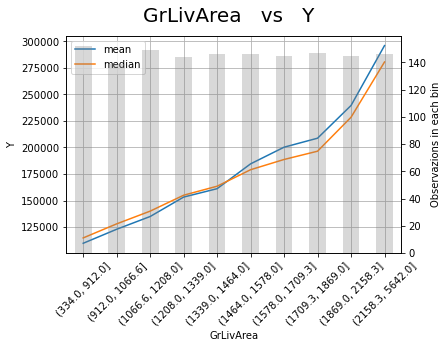

In [68]:
x, y = "GrLivArea", "Y"
### bin plot
dtf_noNan = dtf[dtf[x].notnull()]
breaks = np.quantile(dtf_noNan[x], q=np.linspace(0, 1, 11))
groups = dtf_noNan.groupby([pd.cut(dtf_noNan[x], bins=breaks, 
           duplicates='drop')])[y].agg(['mean','median','size'])
print(groups)
fig, ax = plt.subplots()
fig.suptitle(x+"   vs   "+y, fontsize=20)
groups[["mean", "median"]].plot(kind="line", ax=ax)
groups["size"].plot(kind="bar", ax=ax, rot=45, secondary_y=True,
                    color="grey", alpha=0.3, grid=True)
ax.set(ylabel=y)
ax.right_ax.set_ylabel("Observazions in each bin")
plt.show()

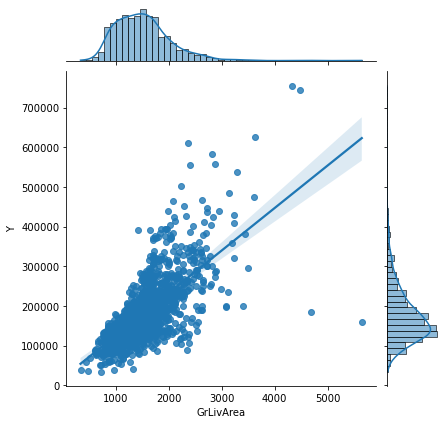

In [69]:
### scatter plot
sns.jointplot(x=x, y=y, data=dtf, dropna=True, kind='reg')
plt.show()

In [70]:
#Checking realtion with the help of Pearson correlation

x, y = "GrLivArea", "Y"
dtf_noNan = dtf[dtf[x].notnull()]
coeff, p = scipy.stats.pearsonr(dtf_noNan[x], dtf_noNan[y])
coeff, p = round(coeff, 3), round(p, 3)
conclusion = "Significant" if p < 0.05 else "Non-Significant"
print("Pearson Correlation:", coeff, conclusion, "(p-value: "+str(p)+")")

Pearson Correlation: 0.709 Significant (p-value: 0.0)


It is clear that *GrLivArea* is predictive, there is a clear pattern: on average, the larger the house the higher the price, even though there are some outliers with an above-average size and a relatively low price.

*FullBath* and *GrLivArea* are examples of predictive features. This kind of analysis should be carried on for each variable in the dataset to decide what should be kept as a potential feature and what can be dropped because not predictive 

## 3. Feature Engineering

It’s time to create new features from raw data using domain knowledge. Here, we use the *MSSubClass* column (the building class) as an example. This categorical variable contains 15 categories, which is a lot and can cause a dimensionality problem during modeling. 

<AxesSubplot:xlabel='Y', ylabel='Count'>

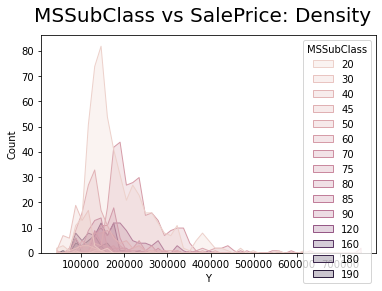

In [72]:
fig, ax = plt.subplots()
fig.suptitle("MSSubClass vs SalePrice: Density", fontsize=20)
sns.histplot(data = dtf, x = "Y", hue = "MSSubClass", element="poly") 

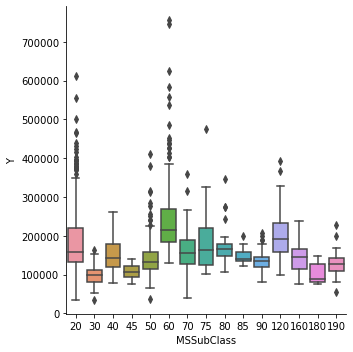

In [73]:
sns.catplot(x="MSSubClass", y="Y", data=dtf, kind="box")

In [74]:
x, y = "MSSubClass", "Y"
## define clusters
MSSubClass_clusters = {"min":[30,45,180], "max":[60,120], "mean":[]}
## create new columns
dic_flat = {v:k for k,lst in MSSubClass_clusters.items() for v in lst}
for k,v in MSSubClass_clusters.items():
    if len(v)==0:
        residual_class = k 
dtf["MSSubClass"+"_cluster"] = dtf[x].apply(lambda x: dic_flat[x] if x in 
                          dic_flat.keys() else residual_class)
dtf

,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,FullBath,YearBuilt,YearRemodAdd,LotFrontage,MSSubClass,Y,MSSubClass_cluster
Id,,,,,,,,,,,,
1,7,1710,2,548,856,2,2003,2003,65.0,60,208500,max
2,6,1262,2,460,1262,2,1976,1976,80.0,20,181500,mean
3,7,1786,2,608,920,2,2001,2002,68.0,60,223500,max
4,7,1717,3,642,756,1,1915,1970,60.0,70,140000,mean
5,8,2198,3,836,1145,2,2000,2000,84.0,60,250000,max
...,...,...,...,...,...,...,...,...,...,...,...,...
1456,6,1647,2,460,953,2,1999,2000,62.0,60,175000,max
1457,6,2073,2,500,1542,2,1978,1988,85.0,20,210000,mean
1458,7,2340,1,252,1152,2,1941,2006,66.0,70,266500,mean


In this way, we reduced the number of categories from 15 to 3. And it is much easier to analysi.

<AxesSubplot:xlabel='Y', ylabel='Count'>

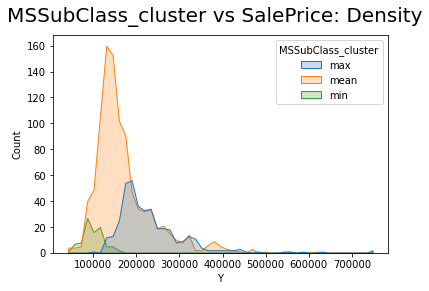

In [77]:
fig, ax = plt.subplots()
fig.suptitle("MSSubClass_cluster vs SalePrice: Density", fontsize=20)
sns.histplot(data = dtf, x = "Y", hue = "MSSubClass_cluster", element="poly") 

## 4. Pre Processing for Our First ML

Data preprocessing is the phase of preparing raw data to make it suitable for a machine learning model. In particular:

- each observation must be represented by a single row, in other words, you can’t have two rows describing the same passenger because they will be processed separately by the model (the dataset is already in such form, so check!). Moreover, each column should be a feature, so you shouldn’t use Id as a predictor, that’s why this kind of table is called “feature matrix”.
- The dataset must be partitioned into at least two sets: the model shall be trained on a significant portion of your dataset (so-called “train set”) and tested on a smaller set (“test set”).
- Missing values should be replaced with something, otherwise, your model may freak out.
- Categorical data must be encoded, which means converting labels into integers because machine learning expects numbers, not strings.
- It’s good practice to scale the data, it helps to normalize the data within a particular range and speed up the calculations in an algorithm.


## 5. ## Feature Selection

**Feature selection** is the process of selecting a subset of relevant variables to build the machine learning model. It makes the model easier to interpret and reduces overfitting (when the model adapts too much to the training data and performs badly outside the train set).

We already did a first “manual” feature selection during data analysis by excluding irrelevant columns. Now it’s going to be a bit different because we have to deal with the **multicollinearity** problem, which refers to a situation in which two or more explanatory variables in a multiple regression model are highly linearly related.

For example: *GarageCars* is highly correlated with *GarageArea* because they both give the same information (how big the garage is, one in terms of how many cars can fit, the other in square feet). Let’s compute the correlation matrix to see it: